In [87]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pearson_util 
import descartes

In [88]:
# here is a comment
df = pd.DataFrame([0, 1, 4])

In [89]:
df[0]

0    0
1    1
2    4
Name: 0, dtype: int64

# This is my data processing part
Here I do A, B, and C

<AxesSubplot:>

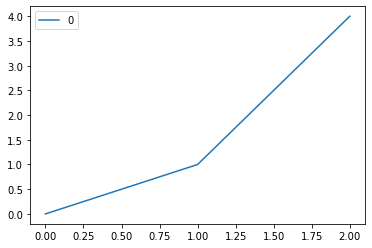

In [90]:
df.plot()

In [91]:
gdf = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_03M_2016_3035_LEVL_3.geojson')

<AxesSubplot:>

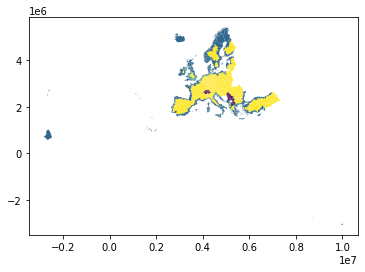

In [92]:
gdf.plot('COAST_TYPE')

In [93]:
gdf.head()

,id,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry
0,EE007,1,4,Kirde-Eesti,EE,EE007,EE007,Kirde-Eesti,3,2,"POLYGON ((5314985.397 4087160.661, 5313113.775..."
1,FRK23,3,2,Drôme,FR,FRK23,FRK23,Drôme,3,3,"MULTIPOLYGON (((3974774.710 2352354.586, 39729..."
2,FRK24,3,2,Isère,FR,FRK24,FRK24,Isère,3,2,"MULTIPOLYGON (((3940042.030 2534830.364, 39405..."
3,AT313,3,3,Mühlviertel,AT,AT313,AT313,Mühlviertel,3,3,"POLYGON ((4596341.521 2829133.754, 4597570.228..."
4,FI200,1,4,Åland,FI,FI200,FI200,Åland,3,3,"MULTIPOLYGON (((4868609.308 4182782.714, 48695..."


In [122]:
#National annual road freight transport by regions of unloading (NUTS 3) and by group of goods (1 000 t), from 2008 onwards (road_go_na_ru3g)
df_unloading = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_na_ru3g.tsv.gz',['subsector', 'unit', 'region'])

In [95]:
df_unloading = df_unloading.loc['TOTAL']

In [96]:
print(df_unloading)

                2019     2018     2017     2016     2015     2014     2013   \
unit  region                                                                  
THS_T AT111    1453.0   1419.0   1192.0   1528.0   1438.0   1161.0   1252.0   
      AT112    7576.0   7076.0   6407.0   7187.0   6817.0   7287.0   6168.0   
      AT113    3059.0   3445.0   3054.0   3058.0   2773.0   2454.0   2994.0   
      AT121   16562.0  17884.0  16044.0  14646.0  15071.0  13014.0  12351.0   
      AT122   14447.0  13639.0  11142.0  11144.0   9014.0  10424.0   8534.0   
...               ...      ...      ...      ...      ...      ...      ...   
      UKN12    2410.0   3417.0      NaN      NaN      NaN      NaN      NaN   
      UKN13    4493.0   3475.0      NaN      NaN      NaN      NaN      NaN   
      UKN14    4711.0   2115.0      NaN      NaN      NaN      NaN      NaN   
      UKN15    5491.0   3111.0      NaN      NaN      NaN      NaN      NaN   
      UKN16    4035.0   4593.0      NaN      NaN    

In [97]:
#National annual road freight transport by regions of loading (NUTS 3) and by group of goods (1 000 t), from 2008 onwards (road_go_na_rl3g
df_loading = pearson_util.load_eurostat_tsv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/road_go_na_rl3g.tsv.gz',['subsector', 'unit', 'region'])

In [98]:
df_loading = df_loading.loc['TOTAL']

In [99]:
print(df_loading)

                2019     2018     2017     2016     2015     2014     2013   \
unit  region                                                                  
THS_T AT111    1395.0   1735.0   1476.0   1746.0   1518.0   1329.0   1331.0   
      AT112    6874.0   7286.0   5852.0   6576.0   6252.0   7517.0   5645.0   
      AT113    3140.0   3826.0   3180.0   3317.0   2790.0   2699.0   3295.0   
      AT121   16877.0  18985.0  17231.0  15224.0  15078.0  13730.0  13176.0   
      AT122   16183.0  15446.0  13899.0  13544.0  10752.0  11774.0   9937.0   
...               ...      ...      ...      ...      ...      ...      ...   
      UKN12    2618.0   3233.0      NaN      NaN      NaN      NaN      NaN   
      UKN13    5583.0   3098.0      NaN      NaN      NaN      NaN      NaN   
      UKN14    4405.0   2621.0      NaN      NaN      NaN      NaN      NaN   
      UKN15    4656.0   4351.0      NaN      NaN      NaN      NaN      NaN   
      UKN16    4005.0   3853.0      NaN      NaN    

In [100]:
df_average_transport = pd.concat((df_unloading, df_loading))

In [101]:
df_average_transport = df_average_transport.groupby(df_average_transport.index).mean()

In [120]:
df_average_transport.head()

,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
"(THS_T, AT111)",1424.0,1577.0,1334.0,1637.0,1478.0,1245.0,1291.5,1633.0,1229.5,1396.5,1675.5,1043.5
"(THS_T, AT112)",7225.0,7181.0,6129.5,6881.5,6534.5,7402.0,5906.5,7163.0,6236.5,5026.0,5432.0,5721.0
"(THS_T, AT113)",3099.5,3635.5,3117.0,3187.5,2781.5,2576.5,3144.5,3281.0,3130.0,3394.5,2348.5,3144.5
"(THS_T, AT121)",16719.5,18434.5,16637.5,14935.0,15074.5,13372.0,12763.5,12487.0,14250.5,13294.5,13310.5,13530.0
"(THS_T, AT122)",15315.0,14542.5,12520.5,12344.0,9883.0,11099.0,9235.5,8654.0,11197.0,9715.0,8602.0,9702.0


In [116]:
print(df_average_transport)

                  2019     2018     2017     2016     2015     2014     2013   \
(THS_T, AT111)   1424.0   1577.0   1334.0   1637.0   1478.0   1245.0   1291.5   
(THS_T, AT112)   7225.0   7181.0   6129.5   6881.5   6534.5   7402.0   5906.5   
(THS_T, AT113)   3099.5   3635.5   3117.0   3187.5   2781.5   2576.5   3144.5   
(THS_T, AT121)  16719.5  18434.5  16637.5  14935.0  15074.5  13372.0  12763.5   
(THS_T, AT122)  15315.0  14542.5  12520.5  12344.0   9883.0  11099.0   9235.5   
...                 ...      ...      ...      ...      ...      ...      ...   
(THS_T, UKN12)   2514.0   3325.0      NaN      NaN      NaN      NaN      NaN   
(THS_T, UKN13)   5038.0   3286.5      NaN      NaN      NaN      NaN      NaN   
(THS_T, UKN14)   4558.0   2368.0      NaN      NaN      NaN      NaN      NaN   
(THS_T, UKN15)   5073.5   3731.0      NaN      NaN      NaN      NaN      NaN   
(THS_T, UKN16)   4020.0   4223.0      NaN      NaN      NaN      NaN      NaN   

                  2012     

In [110]:
#sorting gdf according to id so it might aligne with eurostats data
gdf_sort = gdf.sort_values(by=['id'])

In [104]:
#selecting 2019 column
df_at_2019 = df_average_transport.iloc[:, 0]

In [105]:
print(df_at_2019.iloc[100:105])

(THS_T, BG413)     1979.0
(THS_T, BG414)     1639.0
(THS_T, BG415)      800.5
(THS_T, BG421)    11510.0
(THS_T, BG422)     3019.0
Name: 2019 , dtype: float64


In [111]:
gdf_sort['TRANSPORT_AMOUNT_2019'] = df_at_2019

In [113]:
print(gdf_sort.iloc[100:105])

        id  COAST_TYPE  MOUNT_TYPE    NAME_LATN CNTR_CODE    FID NUTS_ID  \
570  BG325           3           4     Silistra        BG  BG325   BG325   
571  BG331           1           4        Varna        BG  BG331   BG331   
597  BG332           1           4      Dobrich        BG  BG332   BG332   
713  BG333           3           4       Shumen        BG  BG333   BG333   
714  BG334           3           4  Targovishte        BG  BG334   BG334   

     NUTS_NAME  LEVL_CODE  URBN_TYPE  \
570   Силистра          3          3   
571      Варна          3          2   
597     Добрич          3          2   
713      Шумен          3          2   
714  Търговище          3          3   

                                              geometry  TRANSPORT_AMOUNT_2019  
570  POLYGON ((5623303.411 2468347.458, 5625117.978...                    NaN  
571  POLYGON ((5717444.811 2440210.249, 5722100.147...                    NaN  
597  MULTIPOLYGON (((5773956.455 2421445.391, 57705...        

In [115]:
gdf_sort.head()

,id,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry,TRANSPORT_AMOUNT_2019
275,AL011,3,4,Dibër,AL,AL011,AL011,Dibër,3,3,"POLYGON ((5198279.444 2144087.068, 5198325.603...",NaN
276,AL012,1,4,Durrës,AL,AL012,AL012,Durrës,3,2,"POLYGON ((5118781.277 2103409.391, 5123889.702...",NaN
587,AL013,1,4,Kukës,AL,AL013,AL013,Kukës,3,3,"POLYGON ((5169746.713 2142724.545, 5168832.775...",NaN
274,AL014,3,4,Lezhë,AL,AL014,AL014,Lezhë,3,3,"POLYGON ((5141704.826 2105318.036, 5140004.467...",NaN
273,AL015,1,4,Shkodër,AL,AL015,AL015,Shkodër,3,2,"POLYGON ((5129579.170 2204098.752, 5127787.990...",NaN
